<a href="https://colab.research.google.com/github/SergeiVKalinin/ACerS_AE_2024/blob/main/21_Orchestrated_exp_1_modality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Singe modality orchestrated experiment

@prepared Boris Slautin

@supervision Sergei Kalinin

@data by Yongtao Liu and Ilia Ivanov

12/23/2023

In [1]:
!pip install --upgrade git+https://github.com/ziatdinovmax/pyroved.git
!pip install git+https://github.com/ziatdinovmax/gpax@main

!pip install mycolorpy

  Cloning https://github.com/ziatdinovmax/pyroved.git to /tmp/pip-req-build-3e8d4xlf
  Running command git clone --filter=blob:none --quiet https://github.com/ziatdinovmax/pyroved.git /tmp/pip-req-build-3e8d4xlf
  Resolved https://github.com/ziatdinovmax/pyroved.git to commit 7807ffb1cb415b3cc76c1e02d52465a8ae0eeae4
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.2/745.2 kB 6.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mycolorpy import colorlist as mcp

import h5py

import torch
import pyroved as pv

from IPython.core.display import Video
import imageio

import gpax
import numpyro
gpax.utils.enable_x64()

from google.colab import drive

import numpyro.distributions as dist
import jax.numpy as jnp

In [3]:
def normalize(data):
  return [np.min(data),np.ptp(data)], (data - np.min(data))/(np.ptp(data))

## Ground truth dataset

<font color = 'crimson'>`Change this part with your own dataset`</font>

In [4]:
#loops
!gdown https://drive.google.com/uc?id=1rKE6d4T-JHlNOT0K4HExOM83PTHPdy-2 -O /content/90nm.zip

Downloading...
From (original): https://drive.google.com/uc?id=1rKE6d4T-JHlNOT0K4HExOM83PTHPdy-2
From (redirected): https://drive.google.com/uc?id=1rKE6d4T-JHlNOT0K4HExOM83PTHPdy-2&confirm=t&uuid=6c9486c4-c5dc-4831-9437-46d82bc59769
To: /content/90nm.zip
100% 220M/220M [00:04<00:00, 53.7MB/s]


In [5]:
!unzip -q /content/90nm.zip -d /content

In [6]:
# Load all 94*3 loops
all_loops = []


for comp in range (94):
  com_loops = []
  com_coord = []
  for loopnum in range (3):
    hf = h5py.File(r'/content/90nm/BEPS_composition{}_loop{}_0.hf5'.format(comp, loopnum), 'r+')
    beps_qf = hf["BE Quick Fitting/Quick Fitting/Quick Fitting"]
    beps_wv = np.asarray(hf["BEPS/vdc_waveform"])

    com_loops.append(beps_qf[0])
  all_loops.append(com_loops)
all_loops = np.asarray(all_loops)

In [7]:
# correct phase
pha = all_loops[:,:,-1]
mi = np.min(pha)
ma = np.max(pha)

correct_pha = np.where(pha > 1.6, pha + (mi-ma), pha)

correct_pha = correct_pha + np.pi - 1.25
all_loops[:,:,-1] = correct_pha
mean_loops, std_loops = all_loops.mean(1), all_loops.std(1)

In [8]:
# Separate on field and off field loops
loops_on = np.zeros((94, 4, len(beps_wv)))
loops_off = np.zeros((94, 4, len(beps_wv)))

for k in range (len(beps_wv)):
  loops_on[:, :, k] = mean_loops[:, :, 2*k]
  loops_off[:, :, k] = mean_loops[:, :, 1+2*k]

In [9]:
poly_on = loops_on[:,0]*np.cos(loops_on[:,3])
poly_off = loops_off[:,0]*np.cos(loops_off[:,3])

freq_on = loops_on[:,1]
freq_off = loops_off[:,1]

In [10]:
l1,l2 = poly_on.shape
beps_wv_s = beps_wv[:len(beps_wv)//5]

poly_on_s = poly_on.reshape(l1,5,l2//5).mean(1)
poly_off_s = poly_off.reshape(l1,5,l2//5).mean(1)

freq_on_s = freq_on.reshape(l1,5,l2//5).mean(1)
freq_off_s = freq_off.reshape(l1,5,l2//5).mean(1)

Text(0.5, 0.98, 'Blue--> Red corresponds to 20% Sm --> 0% Sm')

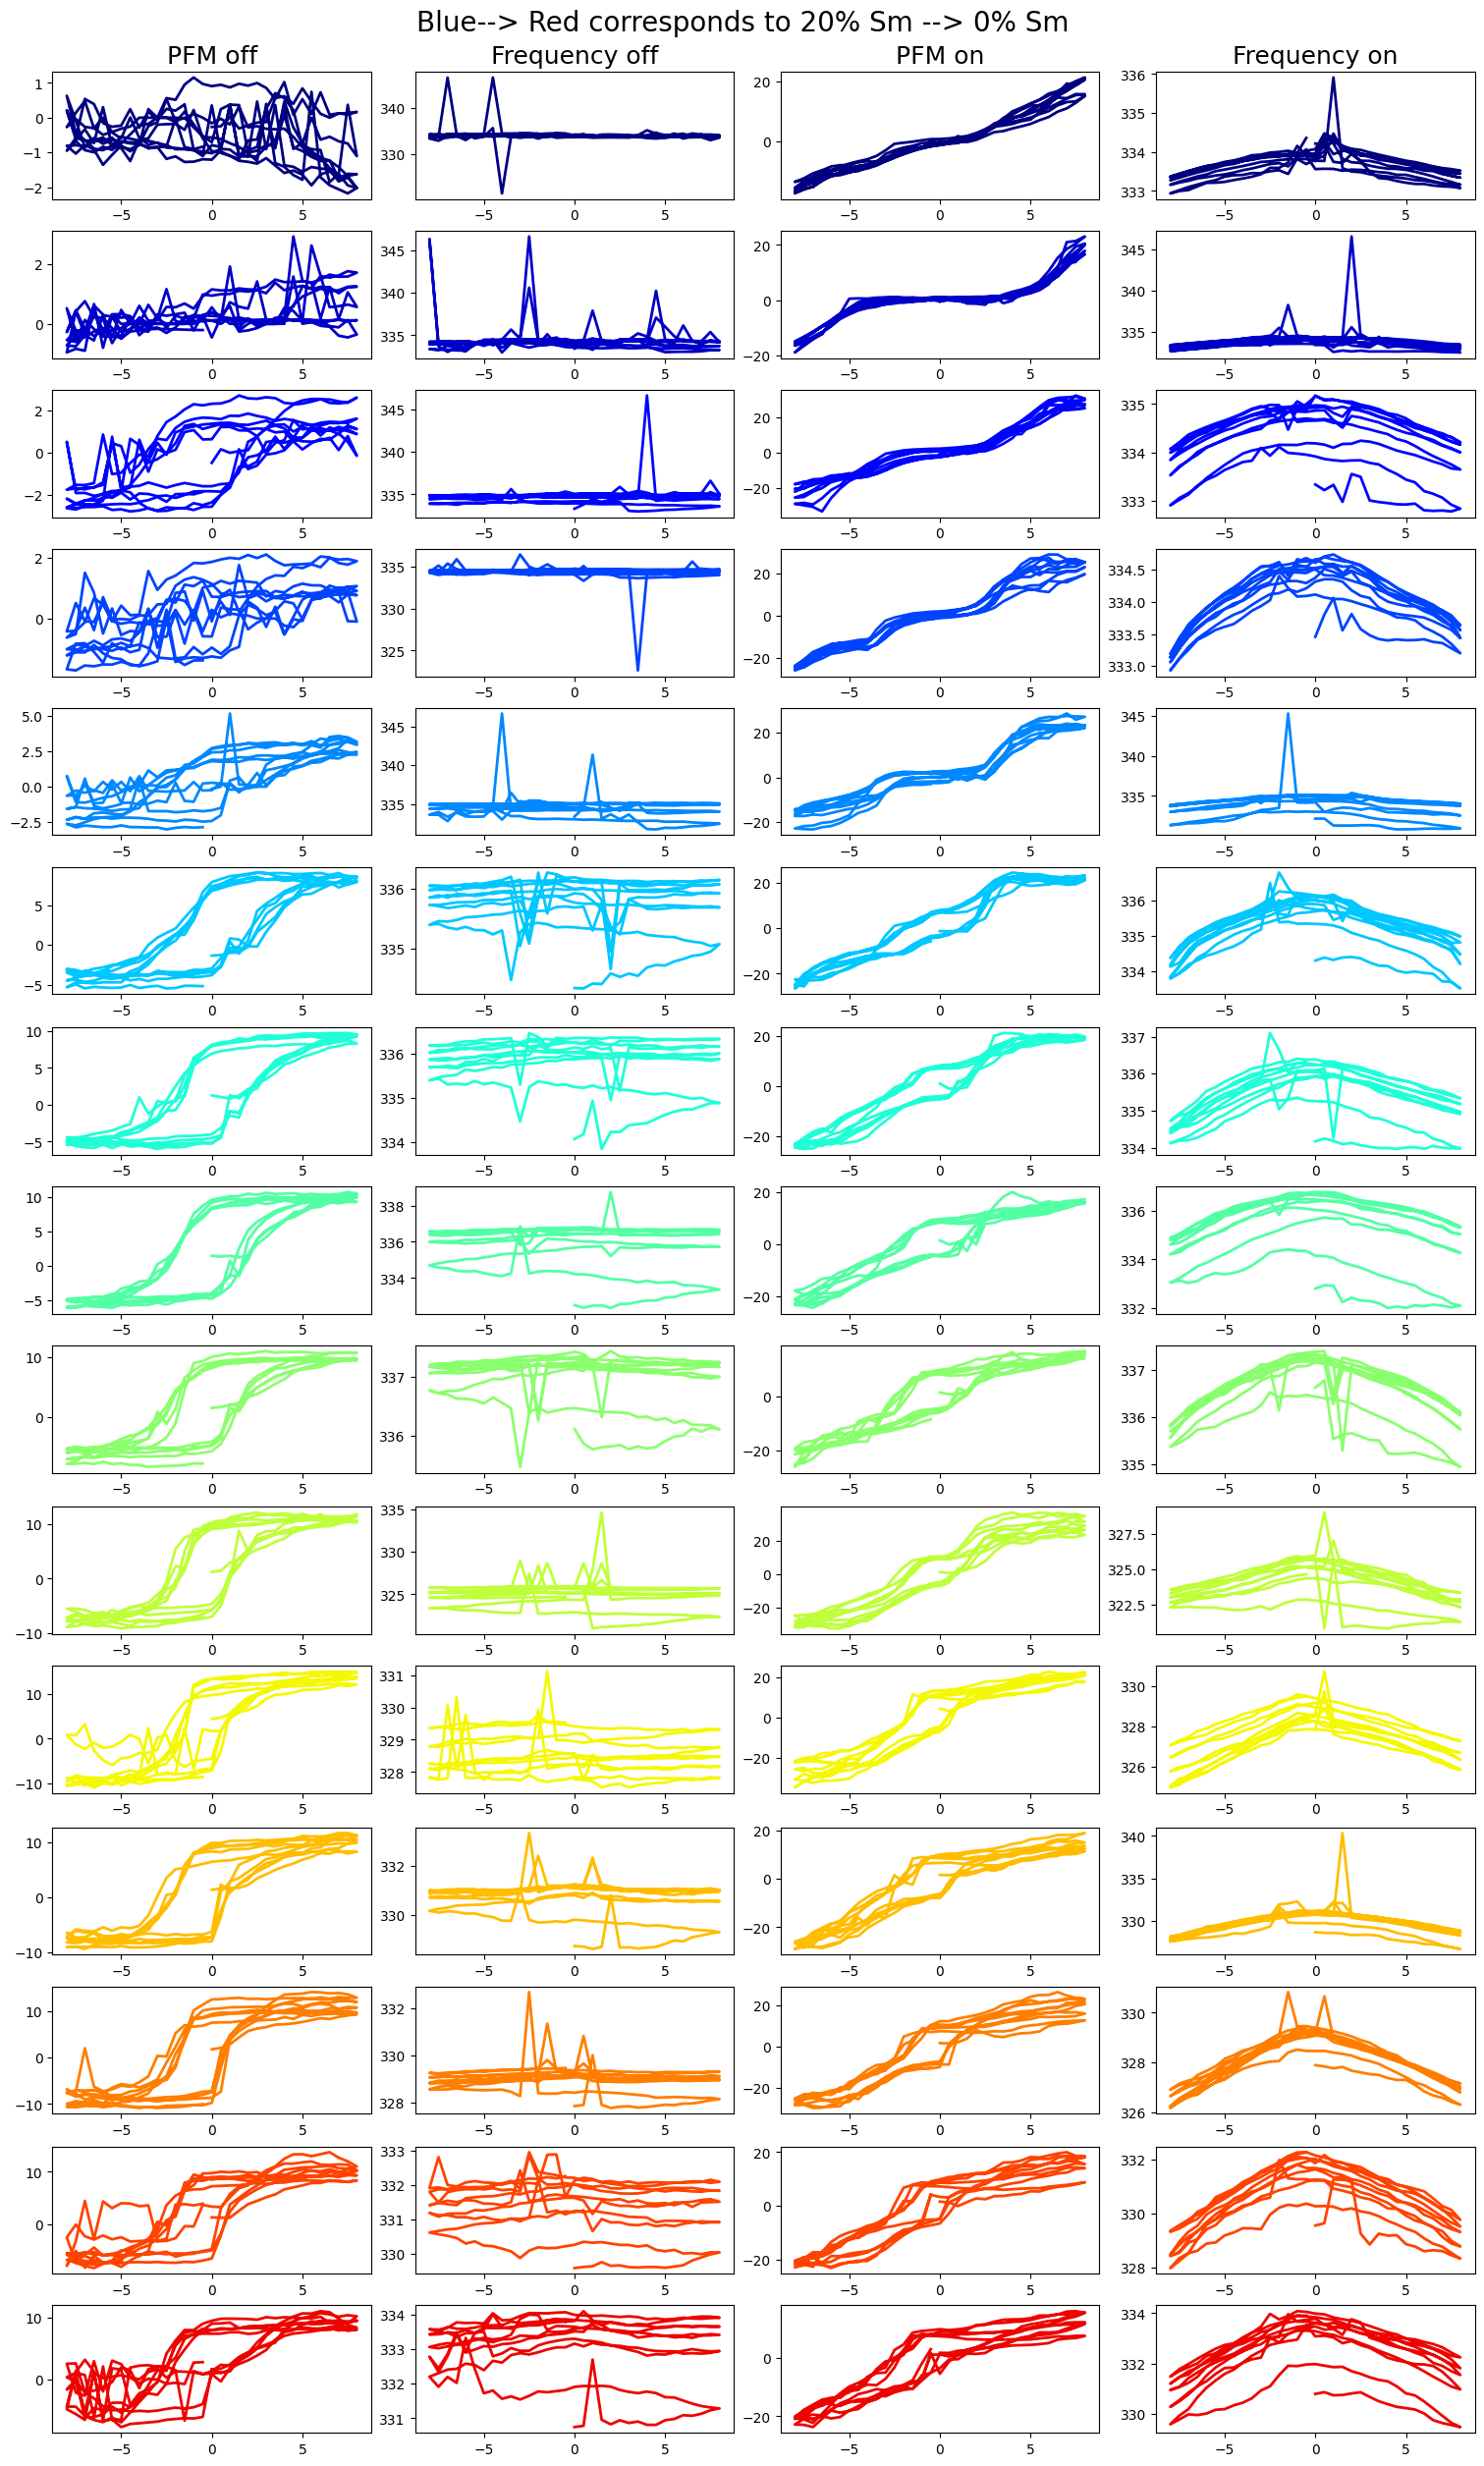

In [11]:
color=mcp.gen_color(cmap="jet",n=94)

fig, ax = plt.subplots(15,4, figsize=(15,25), constrained_layout=True)

ax[0,0].set_title('PFM off', fontsize=18)
ax[0,1].set_title('Frequency off', fontsize=18)
ax[0,2].set_title('PFM on', fontsize=18)
ax[0,3].set_title('Frequency on', fontsize=18)

for i, _ax in enumerate(ax):
  _poly_off = poly_off[l1//15*i]*1E5
  _poly_on = poly_on[l1//15*i]*1E5

  _freq_off = freq_off[l1//15*i]/1E3
  _freq_on = freq_on[l1//15*i]/1E3

  _ax[0].plot(beps_wv, _poly_off, color=color[l1//15*i], lw=2)
  _ax[1].plot(beps_wv, _freq_off, color=color[l1//15*i], lw=2)
  _ax[2].plot(beps_wv, _poly_on, color=color[l1//15*i], lw=2)
  _ax[3].plot(beps_wv, _freq_on, color=color[l1//15*i], lw=2)
fig.suptitle("Blue--> Red corresponds to 20% Sm --> 0% Sm", fontsize=20)

### VAE

In [12]:
signal = poly_off#poly_off #choose the signal for VAE

_, norm_poly = normalize(signal)
vae_data = torch.tensor(norm_poly, dtype=torch.float)
print(vae_data.shape)
vae_loader = pv.utils.init_dataloader(vae_data, batch_size=12)

torch.Size([94, 320])


In [13]:
#VAE input dimension
in_dim = (signal.shape[1],)

vae = pv.models.iVAE(in_dim, latent_dim=2, invariances=None,
                      sampler_d='gaussian', decoder_sig=0.01, seed=42)
# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(vae)

# Train for n epochs:
for e in range(200):
    trainer.step(vae_loader, scale_factor=1)
    trainer.print_statistics()

Epoch: 1 Training loss: 48753.8342
Epoch: 2 Training loss: 24675.1389
Epoch: 3 Training loss: 17964.2561
Epoch: 4 Training loss: 9276.9371
Epoch: 5 Training loss: 7644.5366
Epoch: 6 Training loss: 4841.1793
Epoch: 7 Training loss: 3797.3448
Epoch: 8 Training loss: 3743.7652
Epoch: 9 Training loss: 3439.3310
Epoch: 10 Training loss: 3314.1183
Epoch: 11 Training loss: 3466.1471
Epoch: 12 Training loss: 3431.6690
Epoch: 13 Training loss: 3205.3053
Epoch: 14 Training loss: 3716.6610
Epoch: 15 Training loss: 3461.8417
Epoch: 16 Training loss: 3329.9550
Epoch: 17 Training loss: 3178.3799
Epoch: 18 Training loss: 2935.8641
Epoch: 19 Training loss: 3040.9766
Epoch: 20 Training loss: 2846.2831
Epoch: 21 Training loss: 2859.1987
Epoch: 22 Training loss: 2791.4238
Epoch: 23 Training loss: 2722.1029
Epoch: 24 Training loss: 2695.8775
Epoch: 25 Training loss: 2654.4534
Epoch: 26 Training loss: 2655.0791
Epoch: 27 Training loss: 2588.9042
Epoch: 28 Training loss: 2529.3551
Epoch: 29 Training loss: 2

In [14]:
z_mean, z_std = vae.encode(vae_data)

z1 = z_mean[:, -2]
z2 = z_mean[:, -1]

Text(0.5, 1.0, 'GT VAE BEPS')

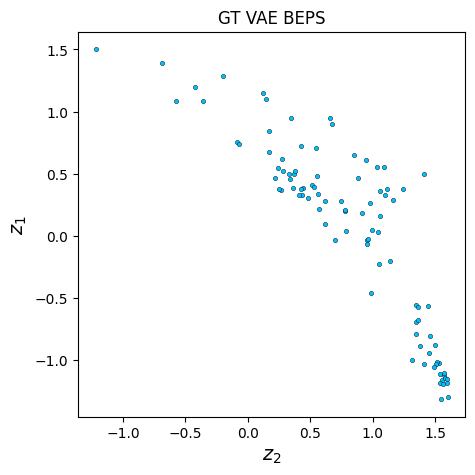

In [15]:
fig = plt.figure(figsize=(5, 5))
plt.scatter(z2, z1, s=10, color='deepskyblue', lw=0.3, edgecolor='black')
plt.xlabel("$z_2$", fontsize=14)
plt.ylabel("$z_1$", fontsize=14)
plt.title('GT VAE BEPS')

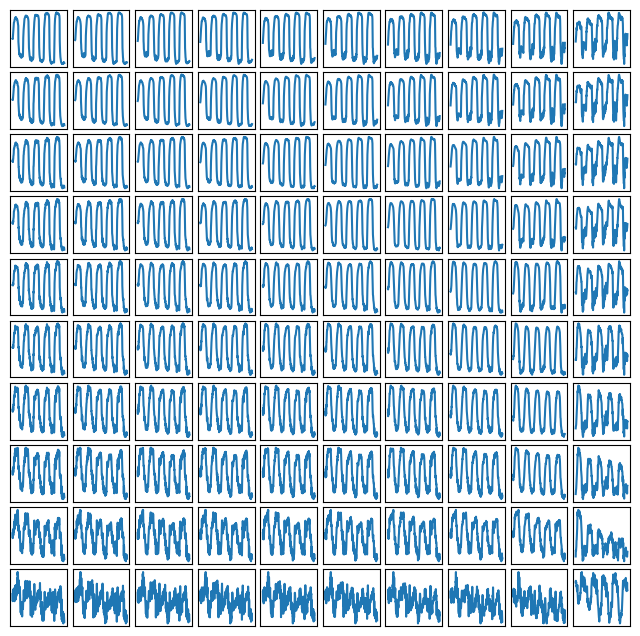

tensor([[0.4901, 0.4869, 0.5290,  ..., 0.0818, 0.0807, 0.0729],
        [0.4770, 0.4807, 0.5378,  ..., 0.0969, 0.0973, 0.0956],
        [0.4637, 0.4796, 0.5390,  ..., 0.1153, 0.1187, 0.1213],
        ...,
        [0.4427, 0.4114, 0.4489,  ..., 0.3531, 0.3187, 0.3054],
        [0.4507, 0.4329, 0.4544,  ..., 0.3882, 0.3574, 0.3453],
        [0.4615, 0.4657, 0.4601,  ..., 0.4611, 0.4453, 0.4415]])

In [16]:
vae.manifold2d(d=10)

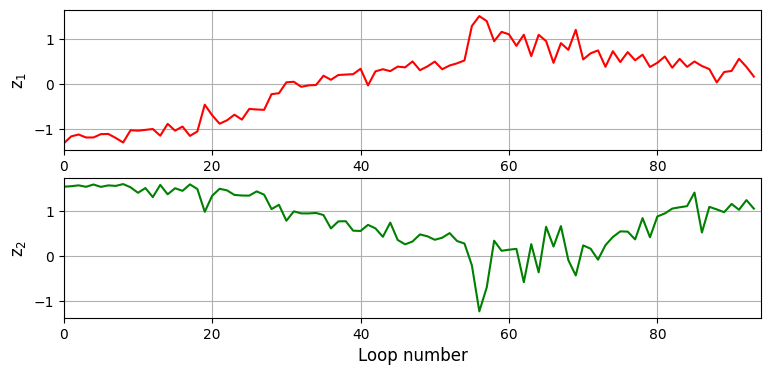

In [17]:
fig, ax = plt.subplots(2, 1, figsize=(9, 4))

ax[0].plot(z1, color='red')
ax[1].plot(z2, color='green')

ax[0].set_ylabel('z$_1$', fontsize=12)
ax[1].set_ylabel('z$_2$', fontsize=12)

for _ in ax.flat:
  _.set_xlim(0,len(z1))
  _.grid()
  _.set_xlabel('Loop number', fontsize=12)

# The orchestrated experiment

In [18]:
#@title VAE & GP functions

from ast import Pass
from gpax import ExactGP
from pyroved.models import iVAE
from typing import Callable, Dict, Optional

#----------- VAE -------------
def VAE(dataset, batch_size=12, latent_dim=2, n_epoch=200, print_statistics=False, test = None):
  norm_coef, norm_data = normalize(dataset)

  vae_data = torch.tensor(norm_data, dtype=torch.float)
  vae_loader = pv.utils.init_dataloader(vae_data)

  in_dim = (dataset.shape[1],)

  vae = pv.models.iVAE(in_dim, latent_dim=latent_dim, invariances=None,
                      sampler_d='gaussian', decoder_sig=0.01, seed=42)

  # Initialize SVI trainer
  trainer = pv.trainers.SVItrainer(vae)

  # Train for n epochs:
  for e in range(n_epoch):
    trainer.step(vae_loader, scale_factor=1)
    if print_statistics:
      trainer.print_statistics()
  if not print_statistics:
    trainer.print_statistics()

  if type(test) !=type(None):
    test_norm = (test - norm_coef[0])/norm_coef[1]
    vae_full = torch.tensor(test_norm, dtype=torch.float)
    full_mean, full_std = vae.encode(vae_full)
    return norm_coef, (full_mean, full_std)
  else:
    z_mean, z_std = vae.encode(vae_data)
    return norm_coef, (z_mean, z_std)

def plot_ld(train, test = None, highlight_latest=True, return_fig=False):
  """
        Plot VAE latent distribution

        Parameters
        ----------
        train: dataset used to train VAE

        test:  full dataset, if available

        highlight_latest: emphasis point, correspondent to the last selected location

        return_fig: return fig object (required if we would like to make video)

        Returns
        -------
        None of plt.fig

  """
  fig, ax = plt.subplots(figsize=(4, 4), dpi=100)
  fig.subplots_adjust(wspace=.3)

  if test is not None:
    ax.scatter(test[:,-2], test[:,-1], color='grey', s=3)
  ax.scatter(train[:,-2], train[:,-1], color='red', s=20, label = 'training')
  if highlight_latest:
    ax.scatter(train[-1,-2], train[-1,-1], color='red', s=60, marker='x', label = 'last_added_point')


  ax.legend()
  for _ in [ax,]:
    _.grid()
    _.set_xlabel('z1')
    _.set_ylabel('z2')
    _.tick_params('both', direction='in')
  plt.show()

  if return_fig:
    return fig


#----------- GP BO -------------

class Orchestrated_BO(ExactGP):
  def __init__(self,
               kernel='Matern',
               lengthscale_prior_dist = None,
               noise_prior_dist = None,
               mean_fn = None,
               mean_fn_prior = None):

     super().__init__(1, kernel=kernel,
                         lengthscale_prior_dist=lengthscale_prior_dist,
                         noise_prior_dist = noise_prior_dist,
                         mean_fn = mean_fn,
                         mean_fn_prior = mean_fn_prior)
     self.keys = gpax.utils.get_keys(1)
     self.X_test  = None
     self.X_train = None
     self.y_train = None

  def iteration(self, X_train, y_train, X_test):
    self.X_test  = X_test
    self.X_train = X_train
    self.y_train = y_train

    self.fit(self.keys[0], X_train, y_train)
    self.y_mean, self.y_sampled = self.predict(self.keys[1], X_test, noiseless=True)

  def visualize_res(self, vae_latents=[], **kwargs):
    if self.X_test is None:
      raise ValueError('You must perform iteration first')

    fig = plt.figure(figsize=(6, 4))
    plt.plot(self.y_mean, c='red', label='Prediction')
    plt.fill_between(self.X_test,
                      self.y_mean - self.y_sampled.squeeze().std(0),
                      self.y_mean + self.y_sampled.squeeze().std(0),
                      alpha=0.3, color='red')

    plt.scatter(self.X_train,
                self.y_train,
                c='red',
                label='Experiment',
                alpha=0.6)
    if len(vae_latents) > 0:
        plt.plot(self.X_test,
                 vae_latents, '--',
                 color='black',
                 label='Ground Truth',
                 alpha=0.5)

    plt.legend(loc='lower center', fontsize=8, ncol=3)
    plt.grid(True)
    plt.show()
    return fig


  def acquisition(self, acq_func='EI', maximize=True, visualize=False):
    if acquisition_function == 'EI':
      _acq = gpax.acquisition.EI(self.keys[1], gp_model, self.X_test, maximize=maximize, noiseless=True)
    elif acquisition_function == 'MU':
      _acq = gpax.acquisition.MU(self.keys[1], gp_model, self.X_test, maximize=maximize, noiseless=True)
    elif acquisition_function == 'UCB':
      _acq = gpax.acquisition.UCB(self.keys[1], gp_model, self.X_test, maximize=maximize, noiseless=True)
    else:
      raise ValueError('Unknown acquisition function')

    _acq = np.array(_acq)
    _acq[np.isnan(_acq)==True] = np.random.uniform(low=0.0, high=1.0, size=_acq[np.isnan(_acq)==True].shape)*1e-3
    self.acq = _acq

    maxacq_idx = _acq.argmax()
    maxacq_val = _acq.max()
    self.nextpt = self.X_test[maxacq_idx]

    fig = None
    if visualize:
      fig = self.vis_acq(nextpt=self.nextpt, maxacq_val=maxacq_val)

    return maxacq_idx, maxacq_val, fig



  def vis_acq(self, nextpt=None, maxacq_val=None):
    fig = plt.figure(figsize=(6, 4))
    plt.plot(self.acq, c='r', label="Acquisition function")

    if (nextpt is not None) and (maxacq_val is not None):
      plt.scatter(x=nextpt, y=maxacq_val, color='k', marker = 'X', s=100, label="Next point")

    plt.legend(loc='lower center', fontsize=8)
    plt.title("Acquisition function")
    plt.grid()
    plt.show()
    return fig

  def get_statistics(self,):
    dict_res = {}

    dict_res['X_train']       = np.array(self.X_train).astype(int)
    dict_res['y_train']       = np.array(self.y_train).astype(float)

    dict_res['X_test']        = np.array(self.X_test).astype(int)

    dict_res['noise']         = self.get_samples(1)['noise'].squeeze().mean(0).astype(float)
    dict_res['k_length']      = self.get_samples(1)['k_length'].squeeze().mean(0).astype(float)

    dict_res['y_res_mean']    = np.array(self.y_mean).astype(float)
    dict_res['y_res_uncertainty'] = np.array(tuple(x.squeeze().std(0) for x in self.y_sampled)).astype(float)
    dict_res['next_point'] = np.array(self.nextpt).astype(int)

    return dict_res

In [42]:
#@title auxiliary functions

import h5py

def convert_to_supported_dtype(arr):
    # Check if array has an object dtype
    if arr.dtype == np.dtype('O'):
        # Attempt conversion to a compatible type (if possible)
        try:
            return arr.astype(np.float64)  # Change to a compatible type (e.g., float)
        except ValueError:
            raise ValueError(f"Cannot convert array '{arr}' to a supported dtype.")
    return arr

def save_dict_to_hdf5(file_path, data_dict):
    def save_data(group, data):
        for key, value in data.items():
            if isinstance(value, dict):
                subgroup = group.create_group(key)
                save_data(subgroup, value)
            elif isinstance(value, np.ndarray):
                # Check and convert object dtype arrays if needed
                value = convert_to_supported_dtype(value)
                group.create_dataset(key, data=value)
            else:
                # Handle other types of data or metadata as needed
                pass

    with h5py.File(file_path, 'w') as f:
        save_data(f, data_dict)

def load_hdf5_to_dict(file_path):
    def load_data(group):
        data = {}
        for key, item in group.items():
            if isinstance(item, h5py.Group):
                data[key] = load_data(item)
            else:
                data[key] = np.array(item)
        return data

    with h5py.File(file_path, 'r') as f:
        data_dict = load_data(f)

    return data_dict

def make_video(path, fig_list, fps=1):
  llist = []
  for f in fig_list:
    f.canvas.draw()
    rgb_array = np.frombuffer(f.canvas.tostring_rgb(), dtype=np.uint8)
    rgb_array = rgb_array.reshape(f.canvas.get_width_height()[::-1] + (3,))
    llist.append(rgb_array)

    imageio.mimwrite(path, llist , fps = fps)

Set scalarizer

In [43]:
scalarizer = poly_off

Set the priors below

In [44]:
#Priors:  None for default choice or select smth specific

#number of initial measurements (no less than 3)
N_seeds = 3
N_seeds = max(N_seeds, 3)

#VAE
latent_dim = 2
n_epoch = 200

#GP inputs
latent_for_gp = -1 #select vae latent to train gp

#lengthscale_prior_dist
ls = dist.Uniform(0, 30)
#noise prior
noise_prior = dist.HalfNormal(0.3)

mean_fn       = None
mean_fn_prior = None

acquisition_function = 'UCB' #or 'UCB', or 'MU'
maximize = True #maximize or minimize acq. func.


#number of exploration steps
N_iteration = 20

Execute the following cell in case of sGP.

In [45]:
#example of priors for structured GP
from typing import Dict

import numpyro
import jax.numpy as jnp

def piecewise(x: jnp.ndarray, params: Dict[str, float]) -> jnp.ndarray:
    """Power-law behavior before and after the transition"""
    return jnp.piecewise(
        x, [x < params["t"], x >= params["t"]],
        [lambda x: x**params["beta1"], lambda x: x**params["beta2"]])


def piecewise_priors():
    # Sample model parameters
    t = numpyro.sample("t", numpyro.distributions.Uniform(40, 80))
    beta1 = numpyro.sample("beta1", numpyro.distributions.LogNormal(0, 1))
    beta2 = numpyro.sample("beta2", numpyro.distributions.LogNormal(0, 1))
    # Return sampled parameters as a dictionary
    return {"t": t, "beta1": beta1, "beta2": beta2}


mean_fn       = piecewise
mean_fn_prior = piecewise_priors


-- VAE (seed locations) --
Epoch: 200 Training loss: -861.0777


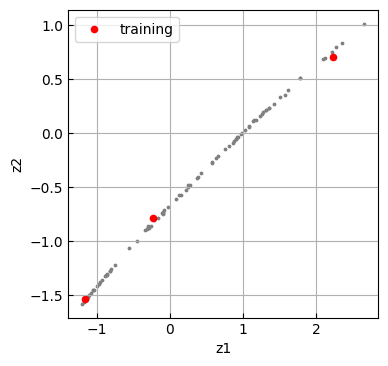


------ Iteration 1 --------


sample: 100%|██████████| 4000/4000 [00:21<00:00, 189.11it/s, 1023 steps of size 1.10e-03. acc. prob=0.83]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta1      1.38      1.63      0.86      0.07      3.17    147.03      1.00
      beta2      0.15      0.06      0.13      0.05      0.24     64.57      1.02
k_length[0]     14.68      8.37     14.88      0.03     25.92     85.17      1.01
    k_scale      2.02      1.67      1.53      0.17      4.21     83.72      1.00
      noise      0.27      0.19      0.24      0.00      0.54    154.56      1.00
          t     50.91      6.83     50.63     40.42     58.71     85.75      1.00



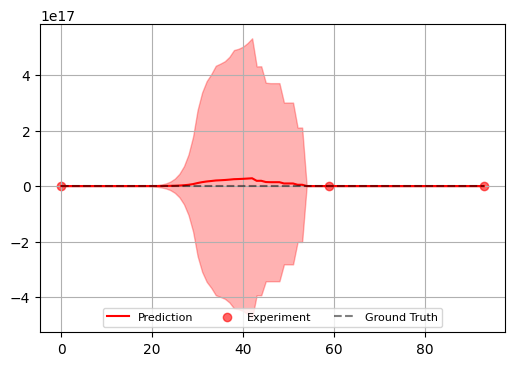

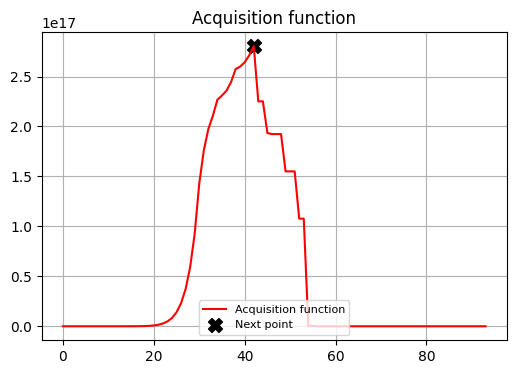


------ Iteration 2 --------

-- VAE iteration 2) --

Epoch: 200 Training loss: 323.9342


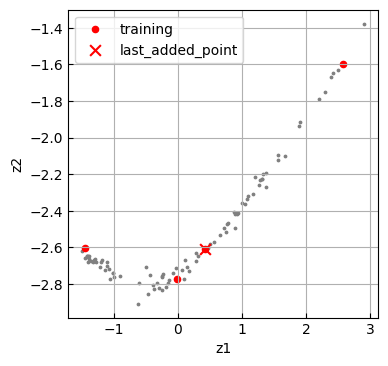

sample: 100%|██████████| 4000/4000 [00:23<00:00, 166.93it/s, 1023 steps of size 9.37e-04. acc. prob=0.81]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta1      0.31      0.30      0.23      0.05      0.52     16.22      1.01
      beta2      0.17      0.07      0.16      0.06      0.27     73.81      1.02
k_length[0]     15.51      5.19     14.64      8.55     23.91      7.94      1.01
    k_scale      6.34      3.42      5.65      1.59     11.23     83.54      1.00
      noise      0.39      0.16      0.37      0.13      0.63     21.80      1.06
          t     55.34     12.66     53.37     40.01     74.39     12.87      1.08



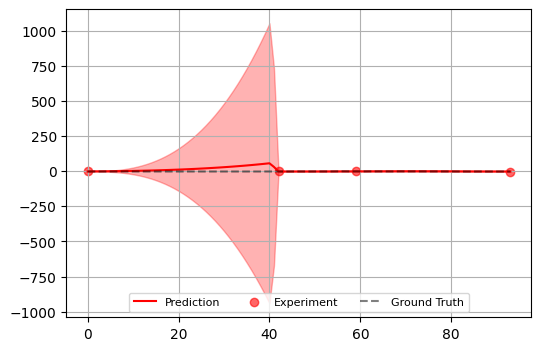

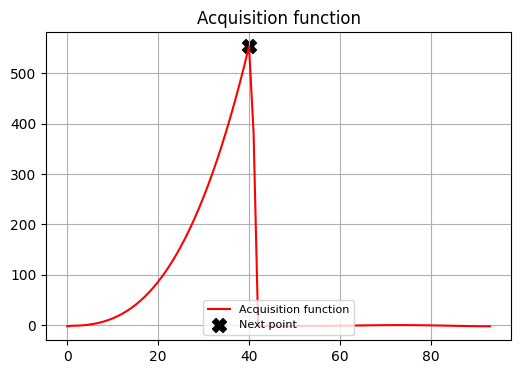


------ Iteration 3 --------

-- VAE iteration 3) --

Epoch: 200 Training loss: 839.1211


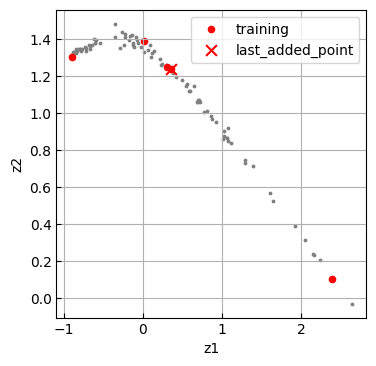

sample: 100%|██████████| 4000/4000 [00:44<00:00, 89.46it/s, 1023 steps of size 9.70e-04. acc. prob=0.78] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta1      0.19      0.07      0.19      0.07      0.29     34.16      1.00
      beta2      0.17      0.07      0.16      0.06      0.28     75.32      1.03
k_length[0]     14.49      9.18     13.87      2.73     29.12      6.97      1.02
    k_scale      1.02      0.78      0.80      0.12      2.04     95.87      1.01
      noise      0.23      0.16      0.19      0.04      0.47      4.10      1.59
          t     59.50     10.31     57.50     45.38     77.79     25.35      1.01



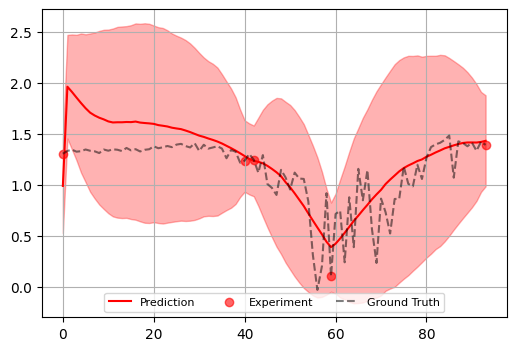

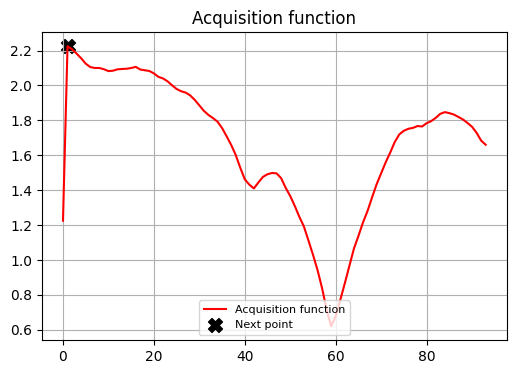


------ Iteration 4 --------

-- VAE iteration 4) --

Epoch: 200 Training loss: 789.8350


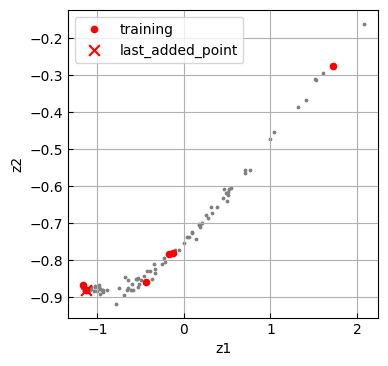

sample: 100%|██████████| 4000/4000 [00:37<00:00, 107.93it/s, 1023 steps of size 1.30e-03. acc. prob=0.76]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta1      0.18      0.08      0.17      0.06      0.29     89.04      1.01
      beta2      0.15      0.07      0.14      0.05      0.27     85.83      1.01
k_length[0]     19.39      6.50     19.04     10.81     29.27      8.30      1.02
    k_scale      2.49      1.79      2.01      0.44      4.67    100.35      1.01
      noise      0.31      0.18      0.28      0.06      0.55     28.08      1.00
          t     61.84      8.89     61.77     47.55     76.06     26.54      1.00



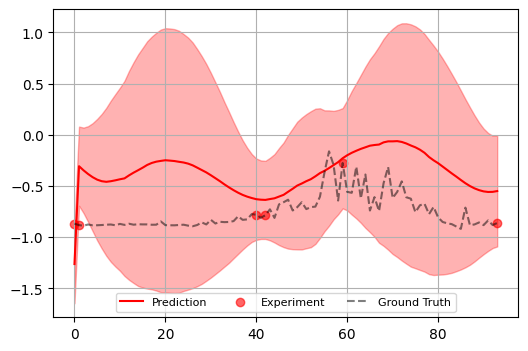

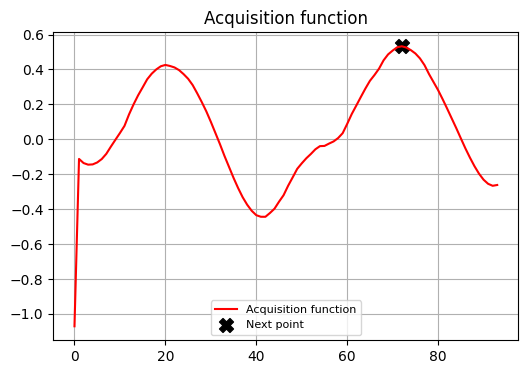


------ Iteration 5 --------

-- VAE iteration 5) --

Epoch: 200 Training loss: 1733.1840


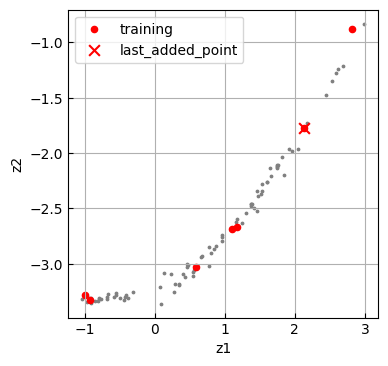

sample: 100%|██████████| 4000/4000 [00:45<00:00, 87.89it/s, 1023 steps of size 6.74e-06. acc. prob=0.98] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta1      1.06      0.00      1.06      1.06      1.06      6.34      1.19
      beta2      0.82      0.00      0.82      0.82      0.82      2.84      3.38
k_length[0]     14.39      0.00     14.39     14.39     14.39      4.39      1.57
    k_scale      6.04      0.00      6.04      6.03      6.04      2.82      2.13
      noise      0.16      0.00      0.16      0.16      0.16      3.60      1.68
          t     58.96      0.00     58.96     58.96     58.97      3.67      1.82



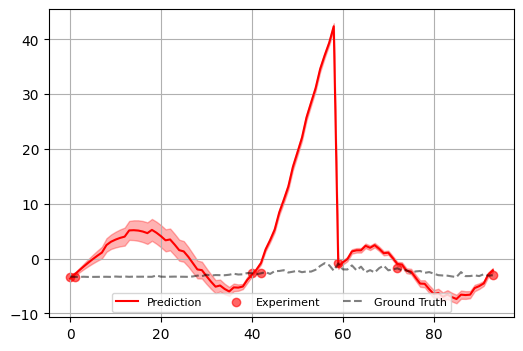

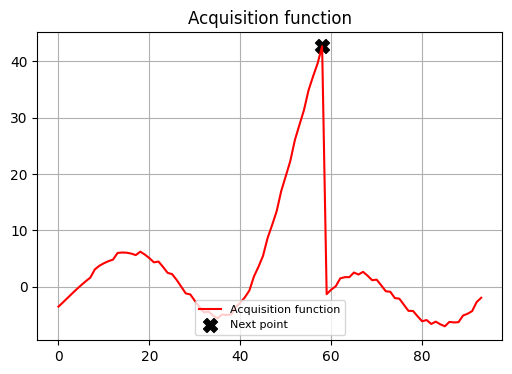


------ Iteration 6 --------

-- VAE iteration 6) --

Epoch: 200 Training loss: 2997.9447


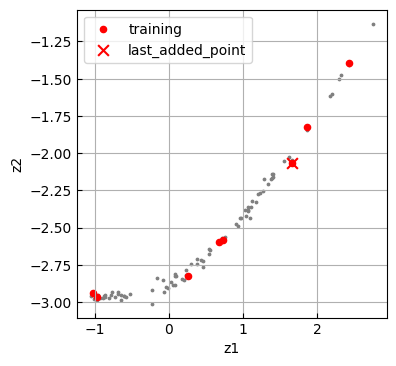

sample: 100%|██████████| 4000/4000 [00:42<00:00, 94.46it/s, 1023 steps of size 9.55e-05. acc. prob=0.89] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta1      0.65      0.03      0.66      0.60      0.68      2.63      2.78
      beta2      0.62      0.02      0.62      0.59      0.66      3.60      1.58
k_length[0]     16.49      0.03     16.49     16.44     16.52      3.88      1.75
    k_scale      9.60      0.21      9.66      9.20      9.86      3.84      1.40
      noise      0.58      0.00      0.58      0.58      0.58      4.60      1.43
          t     58.87      0.07     58.89     58.76     58.97      3.33      1.92



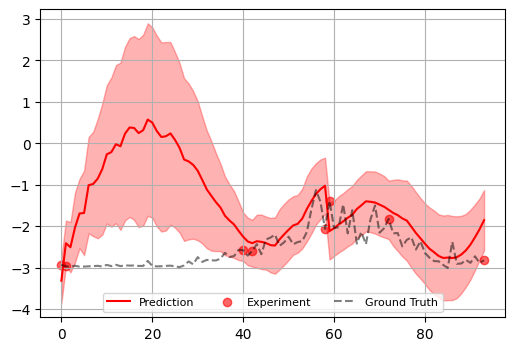

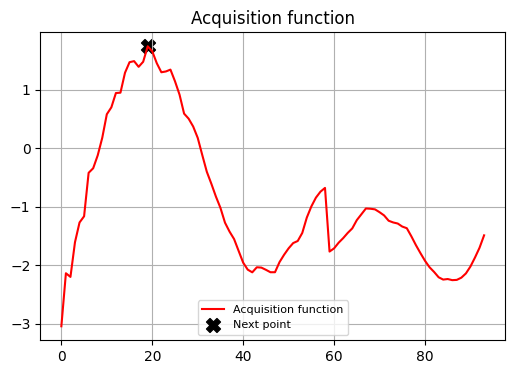


------ Iteration 7 --------

-- VAE iteration 7) --

Epoch: 200 Training loss: 2851.0754


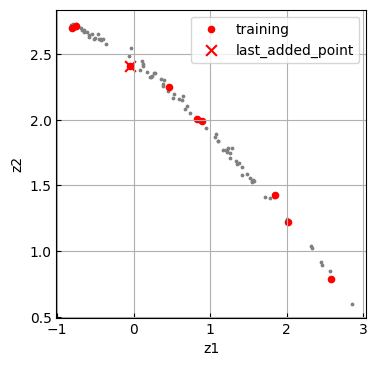

sample: 100%|██████████| 4000/4000 [00:53<00:00, 75.25it/s, 1023 steps of size 6.09e-04. acc. prob=0.77]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta1      0.23      0.08      0.24      0.12      0.36     32.76      1.01
      beta2      0.22      0.07      0.22      0.11      0.32     77.61      1.01
k_length[0]     14.41      8.87     15.74      1.45     26.21      5.11      1.12
    k_scale      1.41      0.86      1.21      0.26      2.55     98.67      1.00
      noise      0.28      0.13      0.27      0.09      0.44     27.26      1.01
          t     60.92     10.71     60.46     46.82     79.45     24.93      1.07



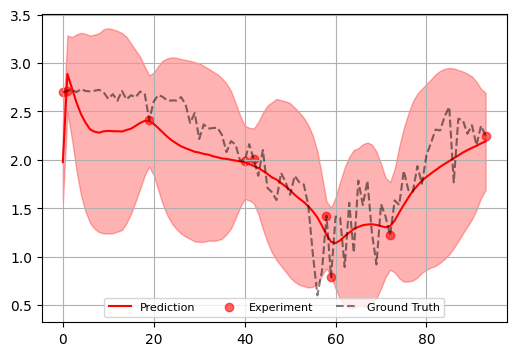

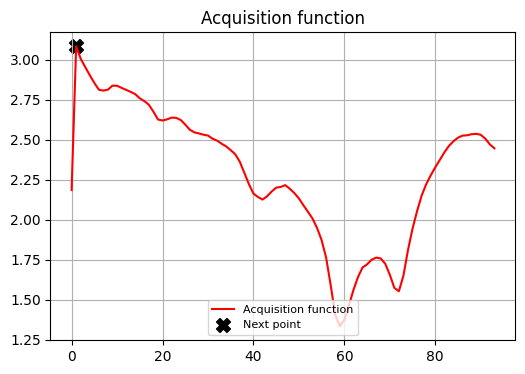


------ Iteration 8 --------

-- VAE iteration 8) --

Epoch: 200 Training loss: 2551.0904


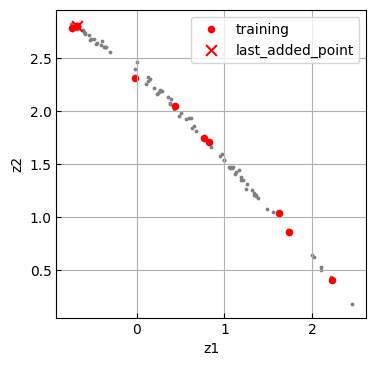

sample: 100%|██████████| 4000/4000 [00:58<00:00, 68.59it/s, 1023 steps of size 6.24e-04. acc. prob=0.80]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta1      0.20      0.08      0.21      0.04      0.31     26.38      1.01
      beta2      0.21      0.07      0.21      0.10      0.32     83.90      1.03
k_length[0]     15.86      9.13     15.69      3.37     29.49      5.69      1.01
    k_scale      1.54      1.06      1.23      0.28      2.97     69.29      1.01
      noise      0.29      0.16      0.28      0.07      0.50     15.74      1.01
          t     62.94     11.76     65.38     46.14     79.60     28.93      1.01



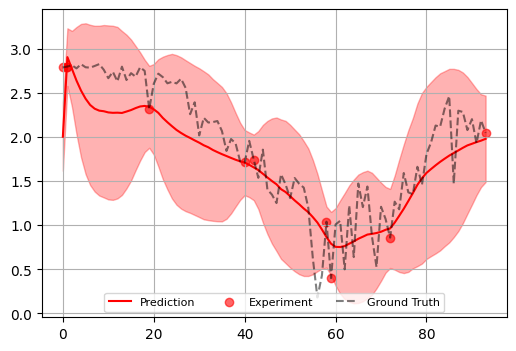

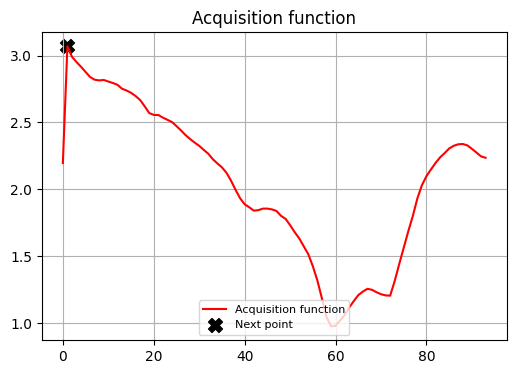


------ Iteration 9 --------

-- VAE iteration 9) --

Epoch: 200 Training loss: 2371.6587


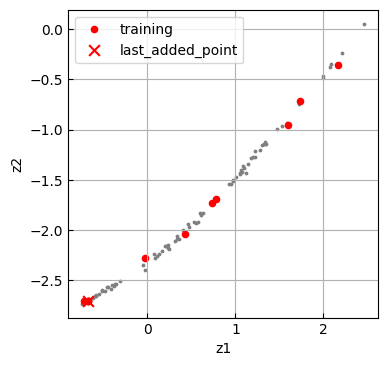

sample: 100%|██████████| 4000/4000 [01:09<00:00, 57.71it/s, 1023 steps of size 5.62e-04. acc. prob=0.76]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta1      0.20      0.08      0.18      0.07      0.32     52.26      1.01
      beta2      0.17      0.07      0.16      0.06      0.28     41.31      1.03
k_length[0]     23.51      4.19     23.76     17.41     29.44      8.57      1.01
    k_scale      4.20      2.29      3.66      1.31      7.06     43.59      1.00
      noise      0.25      0.13      0.23      0.07      0.44     53.16      1.00
          t     63.44     11.66     66.65     46.35     79.60     21.80      1.00



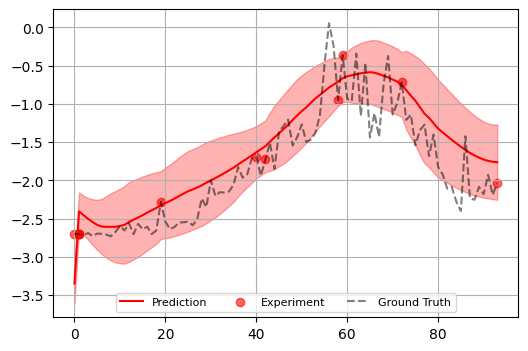

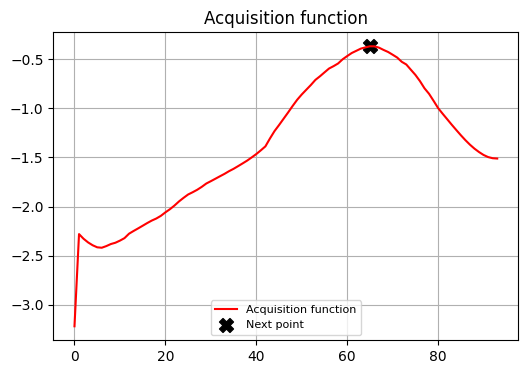


------ Iteration 10 --------

-- VAE iteration 10) --

Epoch: 200 Training loss: 3095.7356


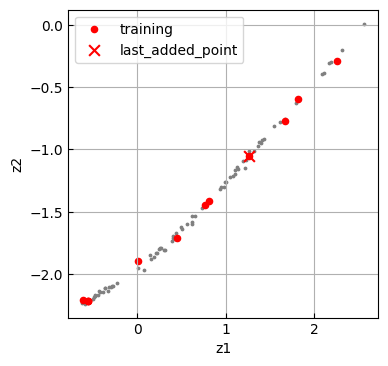

sample: 100%|██████████| 4000/4000 [01:03<00:00, 62.51it/s, 1023 steps of size 7.72e-04. acc. prob=0.76]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta1      0.18      0.07      0.16      0.07      0.29     47.86      1.00
      beta2      0.16      0.07      0.15      0.06      0.26     40.98      1.05
k_length[0]     23.53      3.32     23.55     19.01     28.75      7.85      1.00
    k_scale      3.32      1.64      2.95      1.20      5.31     36.01      1.00
      noise      0.27      0.14      0.23      0.09      0.47     17.99      1.04
          t     66.99      6.73     67.57     55.28     77.15     19.31      1.04



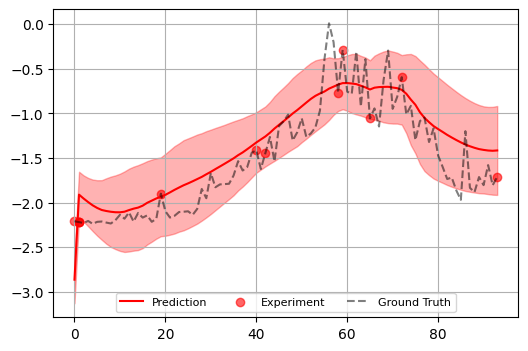

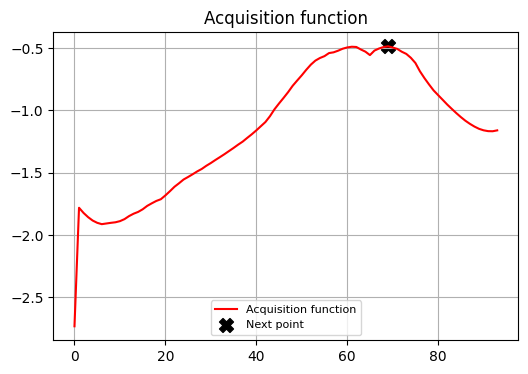


------ Iteration 11 --------

-- VAE iteration 11) --

Epoch: 200 Training loss: 2806.2752


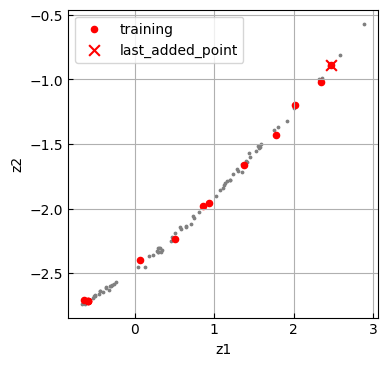

sample: 100%|██████████| 4000/4000 [01:25<00:00, 46.66it/s, 1023 steps of size 6.04e-04. acc. prob=0.75]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta1      0.19      0.08      0.18      0.07      0.30     43.78      1.01
      beta2      0.17      0.07      0.15      0.05      0.28     31.44      1.01
k_length[0]     25.37      3.19     25.51     20.72     29.40      7.93      1.02
    k_scale      4.19      2.14      3.90      1.46      7.08     39.38      1.03
      noise      0.23      0.11      0.21      0.06      0.37     28.15      1.00
          t     61.44     11.20     60.09     46.50     79.11     18.31      1.08



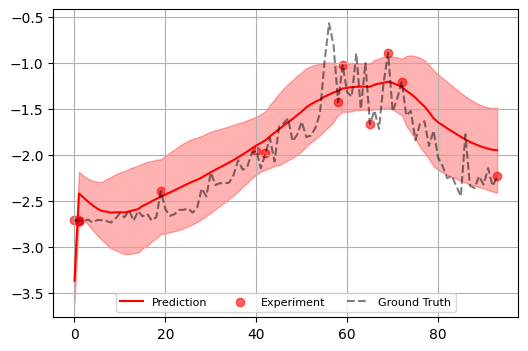

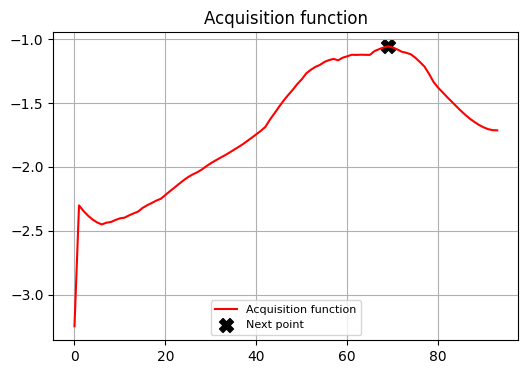


------ Iteration 12 --------

-- VAE iteration 12) --

Epoch: 200 Training loss: 2730.3985


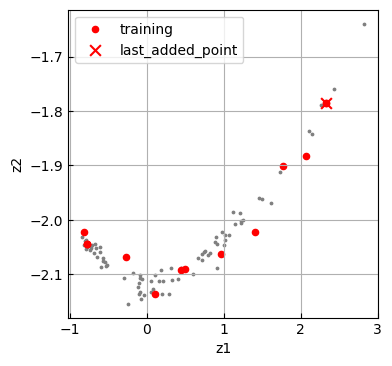

sample: 100%|██████████| 4000/4000 [01:31<00:00, 43.77it/s, 1023 steps of size 3.21e-04. acc. prob=0.93]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta1      0.35      0.07      0.35      0.23      0.47      3.74      1.44
      beta2      0.32      0.06      0.31      0.23      0.42      5.04      1.01
k_length[0]     16.32      0.17     16.31     16.02     16.58      6.12      1.43
    k_scale      8.17      0.97      8.28      6.51      9.53      2.64      2.39
      noise      0.59      0.01      0.59      0.57      0.60      5.51      1.33
          t     59.50      0.90     59.58     57.81     60.61      2.93      2.35



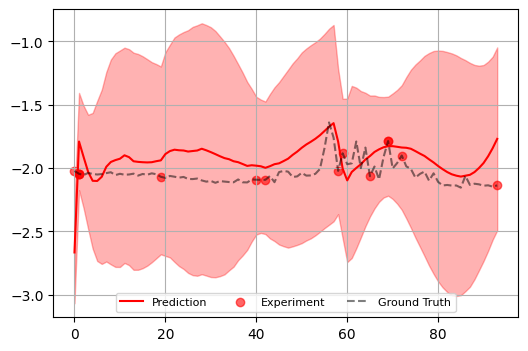

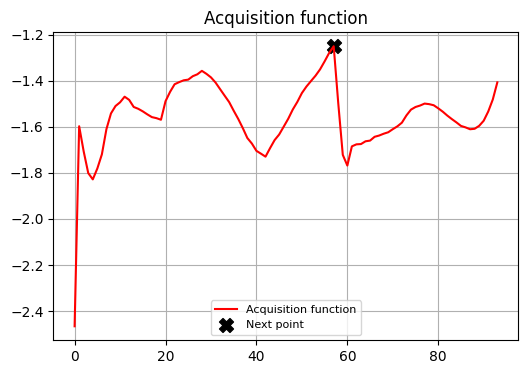


------ Iteration 13 --------

-- VAE iteration 13) --

Epoch: 200 Training loss: 2408.1061


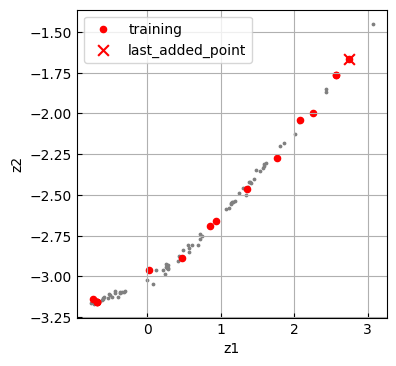

sample: 100%|██████████| 4000/4000 [01:45<00:00, 38.02it/s, 1023 steps of size 4.13e-05. acc. prob=0.86]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta1      0.97      0.00      0.97      0.97      0.98      2.40      3.17
      beta2      0.92      0.00      0.92      0.92      0.92    138.25      1.00
k_length[0]     15.66      0.01     15.66     15.64     15.67      3.40      1.86
    k_scale      7.95      0.02      7.95      7.93      7.98      3.10      1.96
      noise      0.68      0.00      0.68      0.68      0.68      4.38      1.39
          t     58.80      0.01     58.80     58.77     58.82      3.82      1.71



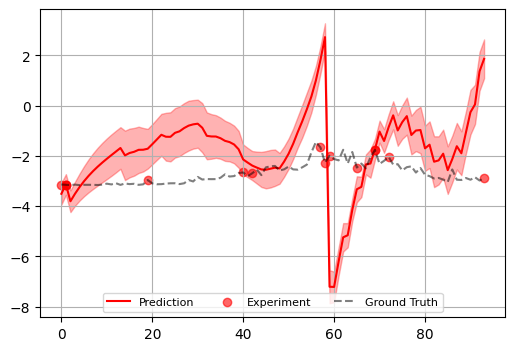

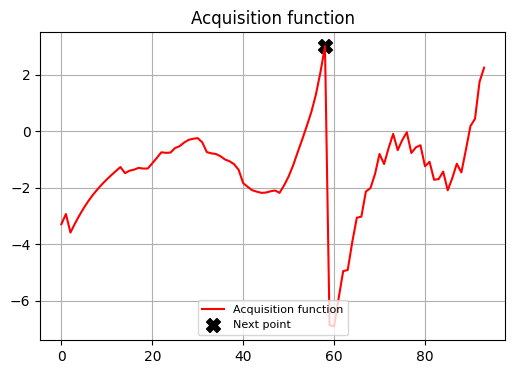


------ Iteration 14 --------

-- VAE iteration 14) --

Epoch: 200 Training loss: 2449.7023


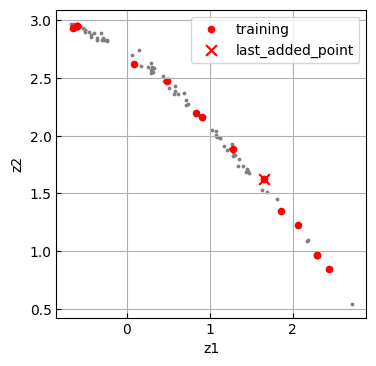

sample: 100%|██████████| 4000/4000 [01:33<00:00, 42.67it/s, 1023 steps of size 1.36e-04. acc. prob=0.89]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta1      0.40      0.05      0.40      0.30      0.48      5.15      1.54
      beta2      0.41      0.04      0.41      0.35      0.46     14.51      1.00
k_length[0]     13.90      0.71     13.65     12.94     15.04      8.17      1.00
    k_scale      7.25      2.14      7.19      3.93     10.32      2.83      2.13
      noise      0.52      0.06      0.51      0.44      0.63      9.48      1.03
          t     59.58      1.42     59.94     57.29     61.76      3.56      1.61



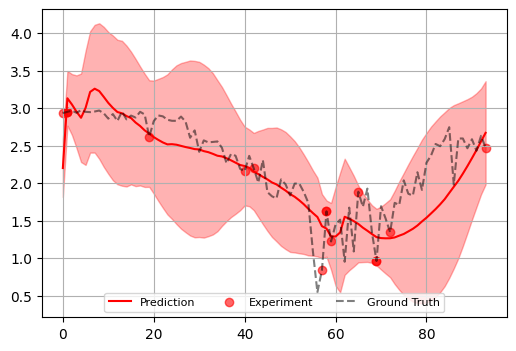

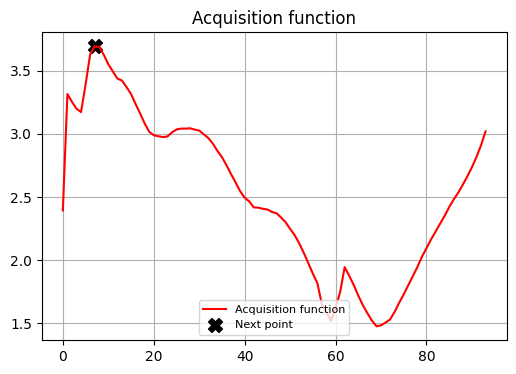


------ Iteration 15 --------

-- VAE iteration 15) --

Epoch: 200 Training loss: 2533.5213


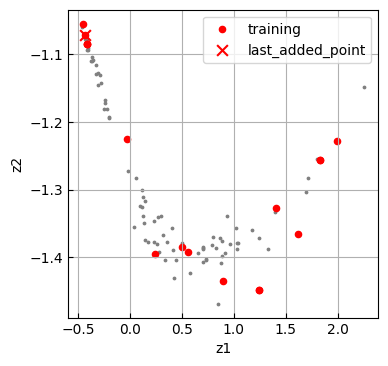

sample: 100%|██████████| 4000/4000 [01:49<00:00, 36.48it/s, 1023 steps of size 1.76e-04. acc. prob=0.93]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta1      0.48      0.06      0.47      0.40      0.58      2.86      2.55
      beta2      0.49      0.04      0.48      0.43      0.57      5.77      1.13
k_length[0]     14.82      0.14     14.79     14.61     15.04      7.49      1.14
    k_scale     10.44      0.94     10.33      8.89     11.91      2.80      2.21
      noise      0.88      0.01      0.88      0.88      0.90      6.68      1.24
          t     58.88      0.22     58.93     58.52     59.18      2.99      2.54



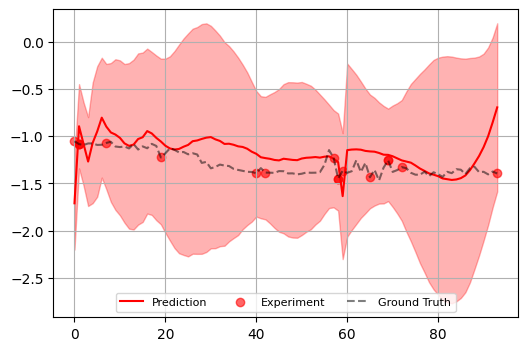

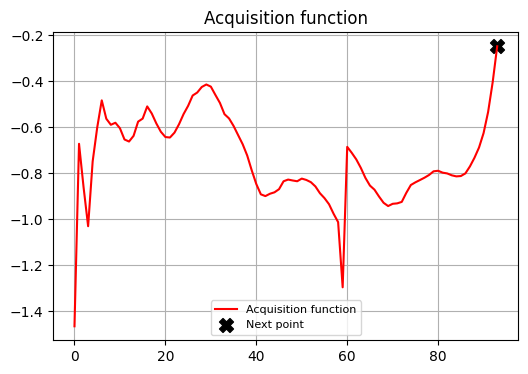


------ Iteration 16 --------

-- VAE iteration 16) --

Epoch: 200 Training loss: 2491.4462


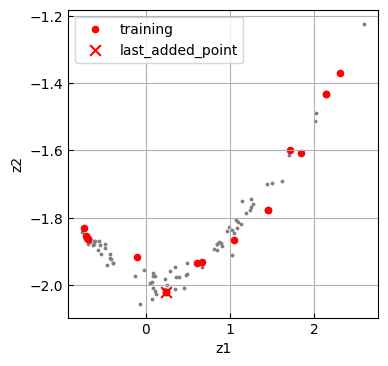

sample: 100%|██████████| 4000/4000 [02:01<00:00, 32.90it/s, 1023 steps of size 8.71e-05. acc. prob=0.89]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta1      0.93      0.01      0.93      0.92      0.95      2.39      3.66
      beta2      0.91      0.01      0.91      0.91      0.92      2.56      2.70
k_length[0]     15.22      0.01     15.22     15.20     15.23      9.06      1.15
    k_scale     10.70      0.11     10.74     10.49     10.85      3.46      1.68
      noise      0.85      0.00      0.85      0.85      0.86      3.54      1.70
          t     58.82      0.02     58.83     58.79     58.85      4.70      1.48



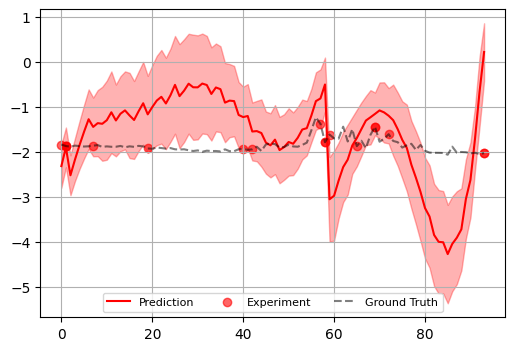

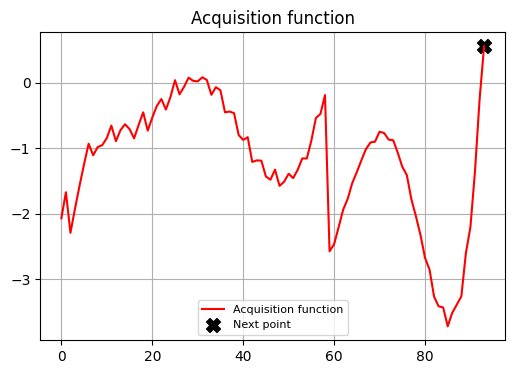


------ Iteration 17 --------

-- VAE iteration 17) --

Epoch: 200 Training loss: 2389.8358


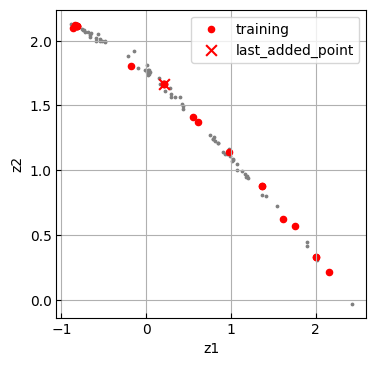

sample: 100%|██████████| 4000/4000 [02:16<00:00, 29.24it/s, 1023 steps of size 7.15e-04. acc. prob=0.73]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta1      0.17      0.06      0.16      0.06      0.27     27.67      1.02
      beta2      0.18      0.06      0.18      0.08      0.28     43.19      1.12
k_length[0]     15.89      5.88     15.04      8.19     26.01      7.05      1.03
    k_scale      0.87      0.62      0.69      0.15      1.68     89.57      1.00
      noise      0.16      0.09      0.14      0.05      0.27     52.05      1.04
          t     68.24      9.05     71.47     53.26     78.87      5.44      1.42



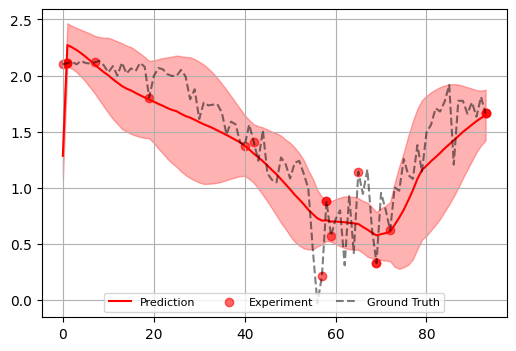

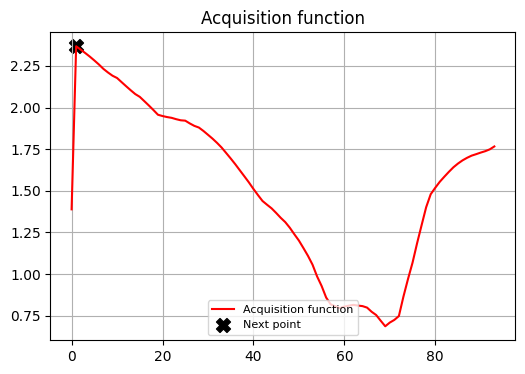


------ Iteration 18 --------

-- VAE iteration 18) --

Epoch: 200 Training loss: 2577.7736


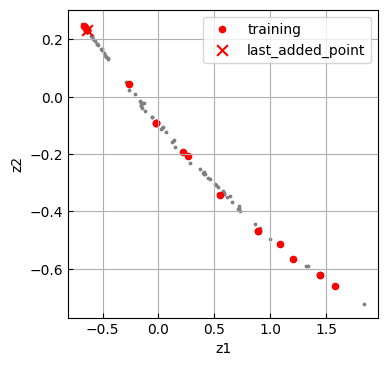

sample: 100%|██████████| 4000/4000 [02:15<00:00, 29.48it/s, 1023 steps of size 1.22e-04. acc. prob=0.86]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta1      0.87      0.04      0.86      0.82      0.92      2.46      2.83
      beta2      0.86      0.03      0.85      0.82      0.91      2.57      2.46
k_length[0]     14.90      0.02     14.90     14.87     14.94      6.82      1.07
    k_scale      9.61      0.06      9.62      9.49      9.68      6.66      1.03
      noise      0.84      0.00      0.84      0.84      0.85      3.37      1.75
          t     58.48      0.06     58.48     58.39     58.58      4.23      1.79



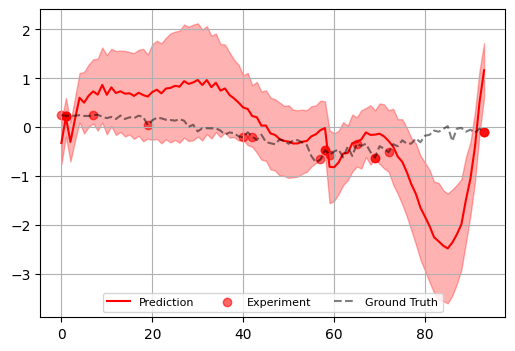

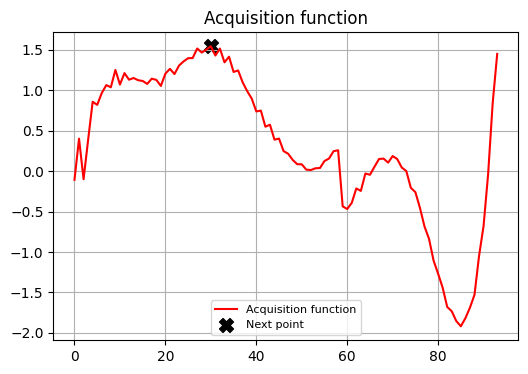


------ Iteration 19 --------

-- VAE iteration 19) --

Epoch: 200 Training loss: 2256.9825


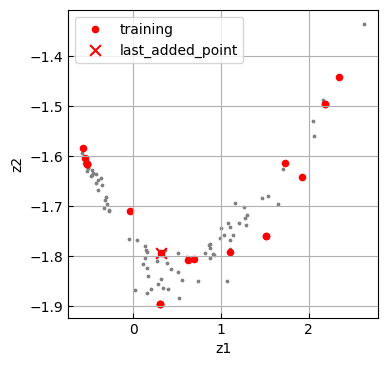

sample: 100%|██████████| 4000/4000 [02:39<00:00, 25.12it/s, 1023 steps of size 6.97e-05. acc. prob=0.90]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta1      1.00      0.00      1.00      1.00      1.00      2.75      2.53
      beta2      0.97      0.00      0.97      0.97      0.97    138.90      1.01
k_length[0]     15.23      0.01     15.23     15.22     15.25      5.10      1.43
    k_scale     10.35      0.01     10.35     10.34     10.35     30.04      1.06
      noise      0.87      0.00      0.87      0.87      0.87      6.69      1.08
          t     58.86      0.02     58.87     58.82     58.91      3.97      1.79



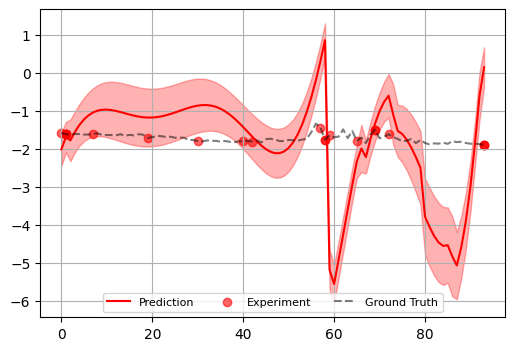

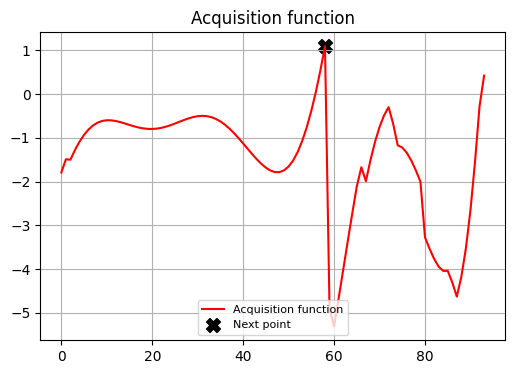


------ Iteration 20 --------

-- VAE iteration 20) --

Epoch: 200 Training loss: 2569.9377


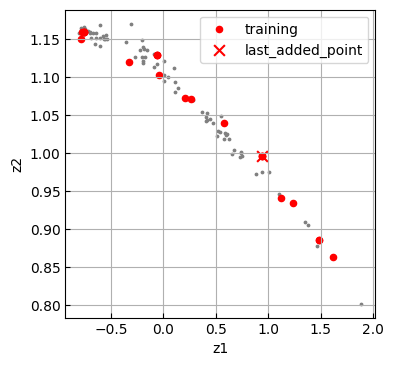

sample: 100%|██████████| 4000/4000 [02:52<00:00, 23.25it/s, 1023 steps of size 2.54e-04. acc. prob=0.82]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta1      0.25      0.07      0.25      0.12      0.36     11.33      1.03
      beta2      0.24      0.04      0.23      0.17      0.30     19.17      1.02
k_length[0]     21.55      2.47     21.61     18.19     25.40      7.92      1.05
    k_scale      5.14      2.51      4.90      1.72      8.63      2.73      2.36
      noise      0.08      0.03      0.07      0.03      0.12     30.12      1.02
          t     55.75      8.05     54.65     44.87     69.98     20.09      1.02



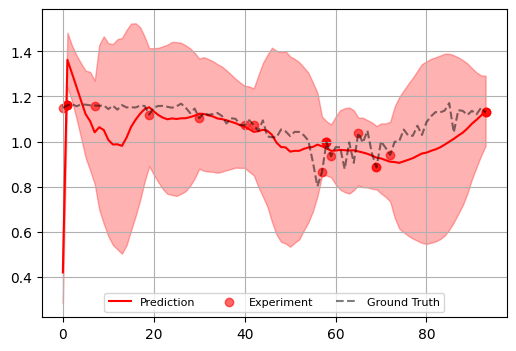

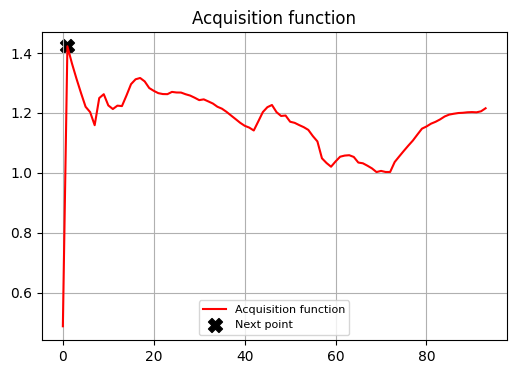

In [46]:
#@title processing
#-------------------------------------------------------
fig_vae = []
fig_acq = []
fig_gp = []

res_stats = {}
#-------------------------------------------------------


X_test = np.arange(len(scalarizer))

#random initial locations including both edges
X_train = np.random.choice(np.arange(1,len(scalarizer)-1), size=N_seeds-2, replace=False)
X_train = np.append(X_train, [0, scalarizer.shape[0]-1])

#VAE train
VAE_train = scalarizer[X_train]

print(f'\n-- VAE (seed locations) --')

_, (z_mean, z_std) = VAE(VAE_train, latent_dim=latent_dim, n_epoch=n_epoch, test=scalarizer)

#z_mean_train is available in the real experiment
z_mean_train = z_mean[X_train]

fig = plot_ld(train = z_mean_train, test = z_mean, return_fig=True, highlight_latest=False)
fig.suptitle('Iteration 0')
fig_vae.append(fig)

#y train for GP
GP_train = z_mean_train[:, latent_for_gp]

#iterations
for iter in range(N_iteration):

  print(f'\n------ Iteration {iter+1} --------')

  #save current state
  res_stats[f'iter {iter}'] = {'VAE':      np.array(z_mean_train).astype(float),
                               'VAE_full': np.array(z_mean).astype(float),}


#VAE
  if iter > 0:
    print(f'\n-- VAE iteration {iter+1}) --\n')
    X_train = np.append(X_train, X_test[maxacq_idx])

    VAE_train = np.append(VAE_train, scalarizer[next_idx][np.newaxis, :], axis=0)

    _, (z_mean, z_std) = VAE(VAE_train, latent_dim=latent_dim, n_epoch=n_epoch, test=scalarizer)

    z_mean_train = z_mean[X_train]

    fig = plot_ld(train = z_mean_train, test = z_mean, return_fig=True)
    fig.suptitle('Iteration {}'.format(iter))
    fig_vae.append(fig)

    #GP_train = np.append(GP_train, 0)
    GP_train = z_mean_train[:,latent_for_gp].squeeze()

#GP BO
  gp_model = Orchestrated_BO(kernel='RBF',
                             lengthscale_prior_dist = ls,
                              noise_prior_dist = noise_prior,
                             mean_fn = mean_fn,
                             mean_fn_prior = mean_fn_prior)

  gp_model.iteration(X_train, np.array(GP_train), X_test)

  fig = gp_model.visualize_res(vae_latents=z_mean[:,latent_for_gp])
  fig_gp.append(fig)

  maxacq_idx, maxacq_val,fig = gp_model.acquisition(acq_func=acquisition_function,
                                                    maximize=True,
                                                    visualize=True)
  fig_acq.append(fig)

  next_idx = X_test[maxacq_idx]

  res_stats[f'iter {iter}'].update(gp_model.get_statistics())

In [47]:
#save results
save_dict_to_hdf5('res.h5', res_stats)

In [48]:
#save figures to the directory

!mkdir figs

for i in range(len(fig_acq)):
  fig_acq[i].savefig('figs/acq_iter_{}.jpeg'.format(i), dpi=300, bbox_inches='tight')
  fig_vae[i].savefig('figs/vae_iter_{}.jpeg'.format(i), dpi=300, bbox_inches='tight')
  fig_gp[i].savefig('figs/gp_iter_{}.jpeg'.format(i), dpi=300, bbox_inches='tight')

mkdir: cannot create directory ‘figs’: File exists


### make videofiles

In [49]:
make_video('vae.mp4', fig_vae, fps=1);

/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


In [50]:
Video('vae.mp4', embed=True)

In [51]:
frame_list = []
for i in range(len(fig_gp)):
  fig_gp[i].set_dpi(100)
  fig_gp[i].suptitle('Iteration {}'.format(i))
  fig_gp[i].canvas.draw()
  rgb_gp = np.frombuffer(fig_gp[i].canvas.tostring_rgb(), dtype=np.uint8)
  rgb_gp = rgb_gp.reshape(fig_gp[i].canvas.get_width_height()[::-1] + (3,))

  fig_acq[i].set_dpi(100)
  fig_acq[i].canvas.draw()
  rgb_acq = np.frombuffer(fig_acq[i].canvas.tostring_rgb(), dtype=np.uint8)
  rgb_acq = rgb_acq.reshape(fig_acq[i].canvas.get_width_height()[::-1] + (3,))

  frame_list.append(np.concatenate([rgb_gp, rgb_acq], axis=1))

imageio.mimwrite('gp.mp4', frame_list , fps = 1)

In [52]:
Video('gp.mp4', embed=True)